## 4.1

In [ ]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# DT from scratch

# load data
!pip install --upgrade --no-cache-dir gdown
!gdown 1hmLfXzalUn4FkQ_pV-V0VNSCdpBRA6Jg

data = pd.read_csv('/content/covid.csv')
print('- - - - - - - - - - - - -')
print("Original DataFrame:")
print(data)

# model

## functional definition of entropy
def entropy(labels):
    p = labels.value_counts() / len(labels)
    return -sum(p * np.log2(p))
Infectad_entropy = entropy(data['Infected'])
print('- - - - - - - - - - - - -')
print("Infectad entropy:")
print(Infectad_entropy)

## information_gain
def information_gain(data, feature, target):
    # Entropy of parent
    entropy_parent = entropy(data[target])

    # Entropy of child
    entropy_child = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        wi = len(subset) / len(data)
        entropy_child += wi * entropy(subset[target])

    return entropy_parent - entropy_child

data.iloc[:, :-1].columns
[information_gain(data, feature, 'Infected') for feature in data.iloc[:, :-1].columns]
max_entropy_node = np.argmax([information_gain(data, feature, 'Infected') for feature in data.iloc[:, :-1].columns])
print('- - - - - - - - - - - - -')
print("Max Information Gain is for coloumn ", max_entropy_node)

## DT and nodes
class Node:

    def __init__(self, feature=None, label=None):
        self.feature = feature
        self.label = label
        self.children = {}

    def __repr__(self):
        if self.feature is not None:
            return f'DecisionNode(feature="{self.feature}", children={self.children})'
        else:
            return f'LeafNode(label="{self.label}")'

def make_tree(data, target):
    # leaf node?
    if len(data[target].unique()) == 1:
        return Node(label=data[target].iloc[0])

    features = data.drop(target, axis=1).columns
    if len(features) == 0 or len(data) == 0:
        return Node(label=data[target].mode()[0])

    # calculate information gain
    gains = [information_gain(data, feature, target) for feature in features]

    # greedy search to find best feature
    max_gain_idx = np.argmax(gains)
    best_feature = features[max_gain_idx]

    # make a node
    node = Node(feature=best_feature)

    # loop over the best feature
    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value].drop(best_feature, axis=1)
        # display(subset)

        node.children[value] = make_tree(subset, target)

    return node

## make tree
tree = make_tree(data, 'Infected')
print('- - - - - - - - - - - - -')
print('tree :', tree)

root_node = tree.feature
print('- - - - - - - - - - - - -')
print('root node is :', root_node)

## visualize
from graphviz import Digraph, nohtml

g = Digraph('g', filename='decision-tree.gv', node_attr={'shape': 'record', 'height': '.1'})

def plot_tree(tree, g):
    root_node = tree.feature
    if root_node is None:
        return g
    g.node(root_node, nohtml(root_node))
    child_nodes = tree.children.keys()
    for i, child in enumerate(child_nodes):
        node = tree.children[child]
        name = node.feature if node.feature is not None else child+node.label
        label = node.feature if node.feature is not None else node.label
        g.node(name, nohtml(label))
        g.edge(root_node, name, label=child)
        plot_tree(node, g)
    return g

g = plot_tree(tree, g)
g.render('decision_tree', format='png', view=True)

## tree with more inf
from graphviz import Digraph, nohtml

def plot_tree(tree, g, parent_name=None, edge_label=None):
    if tree.feature is not None:
        current_node_name = tree.feature
        node_label = (
            f"{tree.feature}\n"
            f"Information Gain: {information_gain(data, tree.feature, 'Infected'):.4f}\n"
            f"Samples: {len(data)}\n"
            f"Samples per Class: {data['Infected'].value_counts().to_dict()}"
        )

    else:
        current_node_name = f"Leaf_{tree.label}"
        node_label = (
            f"Label: {tree.label}\n"
            f"Samples: {len(data)}\n"
            f"Samples per Class: {data['Infected'].value_counts().to_dict()}"
        )

    g.node(current_node_name, label=nohtml(node_label))

    if parent_name is not None:
        g.edge(parent_name, current_node_name, label=edge_label)

    for value, child_node in tree.children.items():
        plot_tree(child_node, g, current_node_name, str(value))

    return g

# Create a new graph
g = Digraph('g', filename='decision-tree-enhanced.gv', node_attr={'shape': 'box'})

# Plot the tree and save the visualization
g = plot_tree(tree, g)
g.render('decision_tree_enhanced', format='png', view=True)


Downloading...
From: https://drive.google.com/uc?id=1hmLfXzalUn4FkQ_pV-V0VNSCdpBRA6Jg
To: /content/covid.csv
100% 258/258 [00:00<00:00, 711kB/s]
- - - - - - - - - - - - -
Original DataFrame:
   Fever Cough Breathing issues Infected
0     No    No               No       No
1    Yes   Yes              Yes      Yes
2    Yes   Yes               No       No
3    Yes    No              Yes      Yes
4    Yes   Yes              Yes      Yes
5     No   Yes               No       No
6    Yes    No              Yes      Yes
7    Yes    No              Yes      Yes
8     No   Yes              Yes      Yes
9    Yes   Yes               No      Yes
10    No   Yes               No       No
11    No   Yes              Yes      Yes
12    No   Yes              Yes       No
13   Yes   Yes               No       No
- - - - - - - - - - - - -
Infectad entropy:
0.9852281360342515
- - - - - - - - - - - - -
Max Information Gain is for coloumn  2
- - - - - - - - - - - - -
tree : DecisionNode(feature="Breathing i

'decision_tree_enhanced.png'

In [ ]:
# ... (previous imports and data loading code)

# Model

## Functional definition of Gini index
def gini(labels):
    class_probabilities = labels.value_counts() / len(labels)
    gini_index = 1 - sum((p ** 2) for p in class_probabilities)
    return gini_index

Infected_gini = gini(data['Infected'])
print('- - - - - - - - - - - - -')
print("Infected Gini Index:")
print(Infected_gini)

## Gini index-based information_gain
def information_gain_gini(data, feature, target):
    # Gini index of parent
    gini_parent = gini(data[target])

    # Gini index of child
    gini_child = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        wi = len(subset) / len(data)
        gini_child += wi * gini(subset[target])

    return gini_parent - gini_child

data.iloc[:, :-1].columns
[information_gain_gini(data, feature, 'Infected') for feature in data.iloc[:, :-1].columns]
max_gini_node = np.argmax([information_gain_gini(data, feature, 'Infected') for feature in data.iloc[:, :-1].columns])
print('- - - - - - - - - - - - -')
print("Max Information Gain (Gini Index) is for column ", max_gini_node)

## Decision Tree and Nodes
class Node:

    def __init__(self, feature=None, label=None):
        self.feature = feature
        self.label = label
        self.children = {}

    def __repr__(self):
        if self.feature is not None:
            return f'DecisionNode(feature="{self.feature}", children={self.children})'
        else:
            return f'LeafNode(label="{self.label}")'

def make_tree_gini(data, target):
    # Leaf node?
    if len(data[target].unique()) == 1:
        return Node(label=data[target].iloc[0])

    features = data.drop(target, axis=1).columns
    if len(features) == 0 or len(data) == 0:
        return Node(label=data[target].mode()[0])

    # Calculate information gain using Gini index
    gains = [information_gain_gini(data, feature, target) for feature in features]

    # Greedy search to find the best feature
    max_gain_idx = np.argmax(gains)
    best_feature = features[max_gain_idx]

    # Make a node
    node = Node(feature=best_feature)

    # Loop over the best feature
    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value].drop(best_feature, axis=1)
        node.children[value] = make_tree_gini(subset, target)

    return node

## Make tree with Gini index
tree_gini = make_tree_gini(data, 'Infected')
print('- - - - - - - - - - - - -')
print('Tree with Gini Index:', tree_gini)

## Visualize with Gini index
from graphviz import Digraph, nohtml

def plot_tree_gini(tree, g, parent_name=None, edge_label=None):
    if tree.feature is not None:
        current_node_name = tree.feature
        node_label = (
            f"{tree.feature}\n"
            f"Gini Index: {information_gain_gini(data, tree.feature, 'Infected'):.4f}\n"
            f"Samples: {len(data)}\n"
            f"Samples per Class: {data['Infected'].value_counts().to_dict()}"
        )

    else:
        current_node_name = f"Leaf_{tree.label}"
        node_label = (
            f"Label: {tree.label}\n"
            f"Samples: {len(data)}\n"
            f"Samples per Class: {data['Infected'].value_counts().to_dict()}"
        )

    g.node(current_node_name, label=nohtml(node_label))

    if parent_name is not None:
        g.edge(parent_name, current_node_name, label=edge_label)

    for value, child_node in tree.children.items():
        plot_tree_gini(child_node, g, current_node_name, str(value))

# Create a new graph
g_gini = Digraph('g_gini', filename='decision-tree-gini.gv', node_attr={'shape': 'box'})

# Plot the tree with Gini index and save the visualization
plot_tree_gini(tree_gini, g_gini)
g_gini.render('decision_tree_gini', format='png', view=True)


## 4.2

breast cancer

Xtrain size = (483, 30) Xtest size = (86, 30)

[Text(0.5769230769230769, 0.875, 'x[7] <= 0.051\nentropy = 0.953\nsamples = 483\nvalue = [180, 303]'), Text(0.3076923076923077, 0.625, 'x[20] <= 16.83\nentropy = 0.303\nsamples = 297\nvalue = [16, 281]'), Text(0.15384615384615385, 0.375, 'x[13] <= 48.7\nentropy = 0.13\nsamples = 278\nvalue = [5, 273]'), Text(0.07692307692307693, 0.125, 'entropy = 0.087\nsamples = 275\nvalue = [3, 272]'), Text(0.23076923076923078, 0.125, 'entropy = 0.918\nsamples = 3\nvalue = [2, 1]'), Text(0.46153846153846156, 0.375, 'x[1] <= 16.19\nentropy = 0.982\nsamples = 19\nvalue = [11, 8]'), Text(0.38461538461538464, 0.125, 'entropy = 0.0\nsamples = 6\nvalue = [0, 6]'), Text(0.5384615384615384, 0.125, 'entropy = 0.619\nsamples = 13\nvalue = [11, 2]'), Text(0.8461538461538461, 0.625, 'x[22] <= 114.45\nentropy = 0.524\nsamples = 186\nvalue = [164, 22]'), Text(0.7692307692307693, 0.375, 'x[21] <= 25.655\nentropy = 0.997\nsamples = 47\nvalue = [25, 22]'), Text(0.6923076

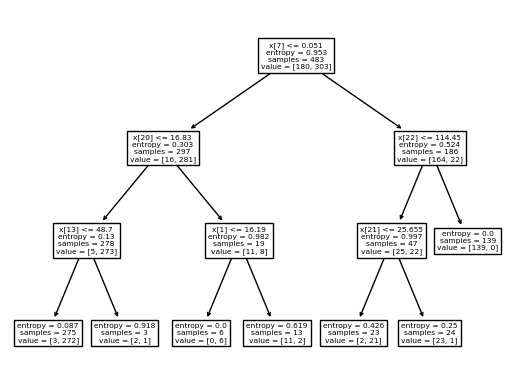

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn import tree

# classification
breast_cancer = load_breast_cancer()
X, y = breast_cancer.data, breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)
X_train_size = X_train.shape
X_test_size = X_test.shape
print('Xtrain size =', X_train_size ,'Xtest size =', X_test_size)
print('')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'ccp_alpha': [0.001, 0.01, 0.1],
    'criterion': ['gini', 'entropy']
}

# Create the grid search object
grid_search = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a new classifier with the best parameters
best_clf = tree.DecisionTreeClassifier(random_state=42, **best_params)
best_clf.fit(X_train, y_train)

DT = tree.plot_tree(best_clf)
print(DT)
print('')

r = tree.export_text(best_clf)
print(r)
print('')

best_clf.predict(X_test)
best_clf.score(X_test, y_test)
best_clf.predict_proba(X_test)

for i in range(len(X_test)):
    decision_path = best_clf.decision_path(X_test[[i]])
    print(f"Decision Path for Sample {i+1}:", decision_path.toarray())
    prediction = best_clf.predict(X_test[[i]])
    print(f"Predicted Class for Sample {i+1}: {prediction[0]}\n")


 max depth = 5 ,ccp alpha = 0.01, gini 


[Text(0.5, 0.75, 'x[4] <= 14.829\ngini = 0.687\nsamples = 180\nvalue = [20, 14, 14, 48, 84]'),
 Text(0.25, 0.25, 'gini = 0.664\nsamples = 96\nvalue = [20, 14, 14, 48, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 84\nvalue = [0, 0, 0, 0, 84]')]

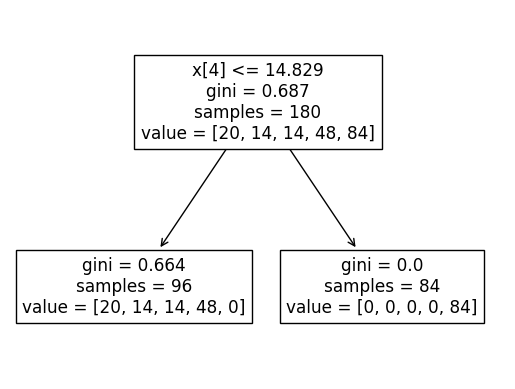

In [36]:
# this cell is for practicing more
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42, ccp_alpha=0.2, criterion='gini')

print(" max depth = 5 ,ccp alpha = 0.01, gini ")
clf.fit(X_train, y_train)
tree.plot_tree(clf)


Drugs

In [1]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()


Saving drug200.csv to drug200.csv


In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pablomgomez21/drugs-a-b-c-x-y-for-decision-trees
!unzip drugs-a-b-c-x-y-for-decision-trees.zip


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open drugs-a-b-c-x-y-for-decision-trees.zip, drugs-a-b-c-x-y-for-decision-trees.zip.zip or drugs-a-b-c-x-y-for-decision-trees.zip.ZIP.


In [28]:
import pandas as pd

# Load the dataset
drugs = pd.read_csv('/content/drug200.csv')


In [29]:
# encode categorical features with label_encoding
from sklearn.preprocessing import LabelEncoder

# initiating the class
label_enc = LabelEncoder()

# columns that are categorical
cols = drugs.select_dtypes(include='O').columns
# looping on each column in the dataset
for col in cols:
    # Label encoding each column
    drugs[col] = label_enc.fit_transform(drugs[col])

# displaying the data after encoding
drugs

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,4
1,47,1,1,0,13.093,2
2,47,1,1,0,10.114,2
3,28,0,2,0,7.798,3
4,61,0,1,0,18.043,4
...,...,...,...,...,...,...
195,56,0,1,0,11.567,2
196,16,1,1,0,12.006,2
197,52,1,2,0,9.894,3
198,23,1,2,1,14.020,3


[Text(0.625, 0.9, 'x[4] <= 14.829\ngini = 0.687\nsamples = 180\nvalue = [20, 14, 14, 48, 84]'), Text(0.5, 0.7, 'x[2] <= 0.5\ngini = 0.664\nsamples = 96\nvalue = [20, 14, 14, 48, 0]'), Text(0.25, 0.5, 'x[0] <= 50.5\ngini = 0.484\nsamples = 34\nvalue = [20, 14, 0, 0, 0]'), Text(0.125, 0.3, 'gini = 0.0\nsamples = 20\nvalue = [20, 0, 0, 0, 0]'), Text(0.375, 0.3, 'gini = 0.0\nsamples = 14\nvalue = [0, 14, 0, 0, 0]'), Text(0.75, 0.5, 'x[2] <= 1.5\ngini = 0.35\nsamples = 62\nvalue = [0, 0, 14, 48, 0]'), Text(0.625, 0.3, 'x[3] <= 0.5\ngini = 0.498\nsamples = 30\nvalue = [0, 0, 14, 16, 0]'), Text(0.5, 0.1, 'gini = 0.0\nsamples = 14\nvalue = [0, 0, 14, 0, 0]'), Text(0.75, 0.1, 'gini = 0.0\nsamples = 16\nvalue = [0, 0, 0, 16, 0]'), Text(0.875, 0.3, 'gini = 0.0\nsamples = 32\nvalue = [0, 0, 0, 32, 0]'), Text(0.75, 0.7, 'gini = 0.0\nsamples = 84\nvalue = [0, 0, 0, 0, 84]')]

|--- feature_4 <= 14.83
|   |--- feature_2 <= 0.50
|   |   |--- feature_0 <= 50.50
|   |   |   |--- class: 0
|   |   |--- fea

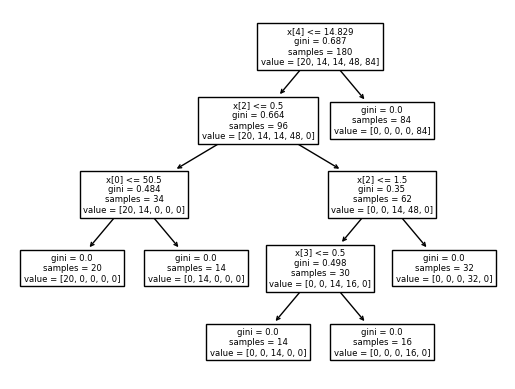

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR
from sklearn.tree import plot_tree

# dividing the data into X, y
X = drugs.drop(columns='Drug')
y = drugs['Drug']
# split the data into train set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
# Building the model
tree_clf0 = DTC()
# Fitting the model
tree_clf0.fit(X_train,y_train)
DT = tree.plot_tree(tree_clf0)
print(DT)
print('')

r = tree.export_text(tree_clf0)
print(r)
print('')

# calculating the accuracy
from sklearn.metrics import accuracy_score, classification_report
y_pred = tree_clf0.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy =',accuracy)

report = classification_report(y_test, y_pred)
print(report)


## 4.3

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import plot_tree

In [ ]:
# load data
!pip install --upgrade --no-cache-dir gdown
!gdown 1cX-RoHkW3ZLYxE0yIyUoz73q8ljh1vmf
df = pd.read_csv('/content/Life_Expectancy_Data.csv')

Downloading...
From: https://drive.google.com/uc?id=1cX-RoHkW3ZLYxE0yIyUoz73q8ljh1vmf
To: /content/Life_Expectancy_Data.csv
100% 306k/306k [00:00<00:00, 122MB/s]


In [ ]:
df.head()


,Country,Continent,Year,Status,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,...,Polio,Total_expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income_composition_of_resources,Schooling
0,Afghanistan,Asia,2015,Developing,65.0,263,62,0.01,71.279624,65.0,...,6.0,8.16,65,0.1,584.259210,33736494,17.2,17.3,0.479,10.1
1,Afghanistan,Asia,2014,Developing,59.9,271,64,0.01,73.523582,62.0,...,58.0,8.18,62,0.1,612.696514,327582,17.5,17.5,0.476,10.0
2,Afghanistan,Asia,2013,Developing,59.9,268,66,0.01,73.219243,64.0,...,62.0,8.13,64,0.1,631.744976,31731688,17.7,17.7,0.470,9.9
3,Afghanistan,Asia,2012,Developing,59.5,272,69,0.01,78.184215,67.0,...,67.0,8.52,67,0.1,669.959000,3696958,17.9,18.0,0.463,9.8
4,Afghanistan,Asia,2011,Developing,59.2,275,71,0.01,7.097109,68.0,...,68.0,7.87,68,0.1,63.537231,2978599,18.2,18.2,0.454,9.5


In [ ]:
print(df.columns)

Index(['Year', 'Life_expectancy', 'Adult_Mortality', 'infant_deaths',
       'Alcohol', 'percentage_expenditure', 'Hepatitis_B', 'Measles', 'BMI',
       'under_five_deaths',
       ...
       'Population_9939678', 'Population_99429', 'Population_996698',
       'Population_9971727', 'Population_9977446', 'Population_99789',
       'Population_997961', 'Population_9987333', 'Population_9999617',
       'Population_Unknown'],
      dtype='object', length=2492)


Mean Squared Error: 5.500702702702704
R^2 Score: 0.9317072903266679


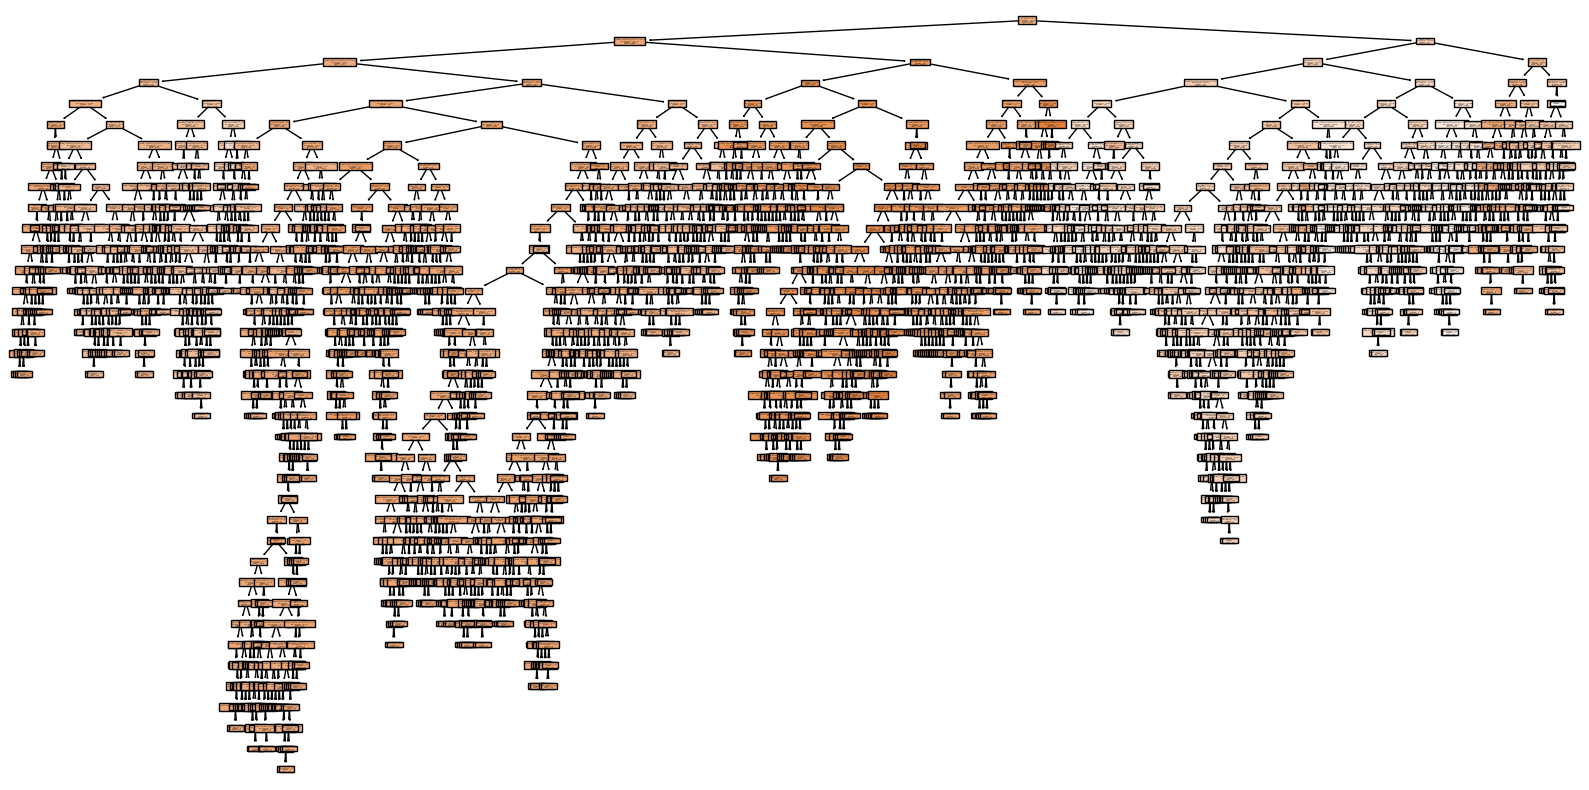

In [ ]:
# imports
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Preprocess the data
# Check missing values
df.fillna(df.mean(), inplace=True)

# convert categorical columns to numerical
df = pd.get_dummies(df, drop_first=True)

# 'Life expectancy' is target column
target_column = 'Life_expectancy'

# If column names have any leading or trailing spaces, remove them
df.columns = df.columns.str.strip()

# define features (X) and target (y)
X = df.drop(columns=[target_column]).values
y = df[target_column].values

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)

# Initialize the DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=13)

# Fit the model on the training data
regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = regressor.predict(X_test)

# Evaluate the model
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

# Visualize the decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(regressor, filled=True, feature_names=df.drop(columns=[target_column]).columns)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=13)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Predict on the test data using the best model
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(X_test)

# Evaluate the model
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best hyperparameters: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error: 5.799563930913609
R^2 Score: 0.9279968474625598
